In [10]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import seaborn as sns
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
table = read_csv('/content/drive/MyDrive/Thesis/csvs/NNdata14_20.csv')
table.head()

Date  IDStation         NameStation  Ammonia  Arsenic  \
0  2014-01-01T00:00:00Z        681  Moggio Loc Penscei      0.0      NaN   
1  2014-01-02T00:00:00Z        681  Moggio Loc Penscei      0.0      NaN   
2  2014-01-03T00:00:00Z        681  Moggio Loc Penscei      0.0      1.1   
3  2014-01-04T00:00:00Z        681  Moggio Loc Penscei      0.0      NaN   
4  2014-01-05T00:00:00Z        681  Moggio Loc Penscei      0.0      NaN   

   Benzo_a_pyrene  Cadmium  Lead  Nikel  NO  ...  IDStation.2  \
0             0.1      NaN   NaN    NaN NaN  ...          111   
1             NaN      NaN   NaN    NaN NaN  ...          111   
2             NaN      0.0   1.1    4.2 NaN  ...          111   
3             0.1      NaN   NaN    NaN NaN  ...          111   
4             NaN      NaN   NaN    NaN NaN  ...          111   

               NameStation.1  Wind_speed  Wind_direction  Temperature  \
0  Cassina Valsassina Moggio    0.443554            99.0    -0.334965   
1  Cassina Valsassina Moggio    0.355915           105.0    -0.486111   
2  Cassina Valsassina Moggio    0.207631           120.0     2.220588   
3  Cassina Valsassina Moggio    1.024926           175.0     2.137063   
4  Cassina Valsassina Moggio    0.666721            94.0     2.416084   

   Relative_humidity  Global_radiation Wind_speed_max  Wind_direction_max  \
0          45.545455         58.097902       1.805594               143.0   
1          83.944444          0.000000       1.767361               153.0   
2          87.042254         30.514085       1.558451               152.0   
3          89.349650          0.202797       3.816783               164.0   
4          86.055944         10.951049       2.797203               136.0   

  Rainfall  
0      0.0  
1      7.8  
2      0.0  
3     35.8  
4     25.0  

[5 rows x 28 columns]

In [13]:
Moggio = table
#PM 2.5 were removed
Moggio = table.loc[:,["Date","PM10","Ammonia","Ozone","Wind_speed","Wind_direction","Temperature","Rainfall","Relative_humidity"]]
Moggio = Moggio.dropna(how="any")
Moggio = Moggio.reset_index()
Moggio = Moggio.iloc[:-365,:] # we train not using 2020, for now
Moggio.head()


index                  Date  PM10  Ammonia  Ozone  Wind_speed  \
0      0  2014-01-01T00:00:00Z   6.0      0.0   71.9    0.443554   
1      1  2014-01-02T00:00:00Z   6.0      0.0   76.8    0.355915   
2      2  2014-01-03T00:00:00Z  11.0      0.0   66.6    0.207631   
3      3  2014-01-04T00:00:00Z   6.0      0.0   77.2    1.024926   
4      4  2014-01-05T00:00:00Z   3.0      0.0   66.2    0.666721   

   Wind_direction  Temperature  Rainfall  Relative_humidity  
0            99.0    -0.334965       0.0          45.545455  
1           105.0    -0.486111       7.8          83.944444  
2           120.0     2.220588       0.0          87.042254  
3           175.0     2.137063      35.8          89.349650  
4            94.0     2.416084      25.0          86.055944

In [14]:
# sns.lineplot(x='Date', y='PM25', data=Moggio)

##Convert series to supervised learning
### Activation function = tanh and logistic (s curve)

###Conversion Function

In [15]:
from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

### Conversion of Moggio

In [19]:
values = Moggio.iloc[:,2:].values
# ensure all data is float
values = values.astype('float32') #cast in float 32 bit per evitare problemi
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
n_days = 5 #Memoria della NN
reframed = series_to_supervised(scaled, n_days, 1) # info of the past 5 days to determine next (1) day
# drop columns we don't want to predict (we therefore keep Ammonia)
reframed.drop(reframed.columns[[41,42,43,44,45,46,47]], axis=1, inplace=True)

reframed.head()

var1(t-5)  var2(t-5)  var3(t-5)  var4(t-5)  var5(t-5)  var6(t-5)  \
5   0.066667        0.0   0.265198   0.161974   0.275000   0.286365   
6   0.066667        0.0   0.283815   0.129068   0.291667   0.282413   
7   0.122222        0.0   0.245061   0.073391   0.333333   0.353183   
8   0.066667        0.0   0.285334   0.380262   0.486111   0.350999   
9   0.033333        0.0   0.243541   0.245766   0.261111   0.358295   

   var7(t-5)  var8(t-5)  var1(t-4)  var2(t-4)  ...  var8(t-2)  var1(t-1)  \
5   0.000000   0.376259   0.066667        0.0  ...   0.879033   0.033333   
6   0.035199   0.816993   0.122222        0.0  ...   0.841229   0.022222   
7   0.000000   0.852549   0.066667        0.0  ...   0.613024   0.077778   
8   0.161552   0.879033   0.033333        0.0  ...   0.620101   0.044444   
9   0.112816   0.841229   0.022222        0.0  ...   0.738562   0.044444   

   var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  var7(t-1)  \
5        0.0   0.243541   0.245766   0.261111   0.358295   0.112816   
6        0.0   0.279255   0.074638   0.222222   0.406390   0.000000   
7        0.0   0.286094   0.033073   0.150000   0.397825   0.000000   
8        0.0   0.284574   0.200156   0.269444   0.408315   0.000000   
9        0.0   0.277736   0.062363   0.100000   0.392536   0.000000   

   var8(t-1)   var1(t)  
5   0.841229  0.022222  
6   0.613024  0.077778  
7   0.620101  0.044444  
8   0.738562  0.044444  
9   0.807349  0.133333  

[5 rows x 41 columns]

In [20]:
# split into train and test sets
values = reframed.values
n_features = 8 # number of variables, including the one to be predicted
n_train_days = 1312 # we train using only the first year
train = values[:n_train_days, :]
test = values[n_train_days:, :] # we test using all successive years 
# split into input and outputs
n_obs = n_days * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
# reshape from 2D to 3D
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1312, 40) 1312 (1312,)
(1312, 5, 8) (1312,) (368, 5, 8) (368,)


# Modeling and training

Epoch 1/500
14/14 - 14s - loss: 0.1125 - val_loss: 0.0967 - 14s/epoch - 982ms/step
Epoch 2/500
14/14 - 0s - loss: 0.0965 - val_loss: 0.0897 - 315ms/epoch - 22ms/step
Epoch 3/500
14/14 - 0s - loss: 0.0922 - val_loss: 0.0887 - 374ms/epoch - 27ms/step
Epoch 4/500
14/14 - 1s - loss: 0.0911 - val_loss: 0.0863 - 617ms/epoch - 44ms/step
Epoch 5/500
14/14 - 1s - loss: 0.0893 - val_loss: 0.0841 - 519ms/epoch - 37ms/step
Epoch 6/500
14/14 - 1s - loss: 0.0883 - val_loss: 0.0844 - 570ms/epoch - 41ms/step
Epoch 7/500
14/14 - 0s - loss: 0.0881 - val_loss: 0.0849 - 471ms/epoch - 34ms/step
Epoch 8/500
14/14 - 0s - loss: 0.0878 - val_loss: 0.0853 - 482ms/epoch - 34ms/step
Epoch 9/500
14/14 - 1s - loss: 0.0871 - val_loss: 0.0837 - 570ms/epoch - 41ms/step
Epoch 10/500
14/14 - 0s - loss: 0.0868 - val_loss: 0.0837 - 472ms/epoch - 34ms/step
Epoch 11/500
14/14 - 0s - loss: 0.0865 - val_loss: 0.0836 - 377ms/epoch - 27ms/step
Epoch 12/500
14/14 - 0s - loss: 0.0861 - val_loss: 0.0834 - 393ms/epoch - 28ms/step
E

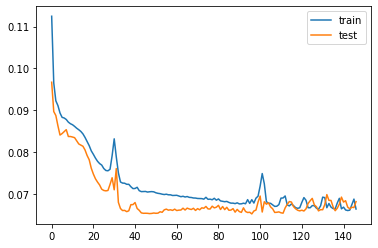

In [21]:
# design the neural network
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
early_stopping = EarlyStopping(patience=50, restore_best_weights = True)
history = model.fit(train_X, train_y, epochs=500, batch_size=100, validation_data=(test_X, test_y), verbose=2, shuffle=False, callbacks=early_stopping)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

## Predictions of the year 2019

prediction with 2020

In [34]:
#Moggio = table.loc[table.loc[:,"NameStation"]=="Moggio",:]
#PM 2.5 were removed
Moggio = table.loc[:,["Date","PM10","Ammonia","Ozone","Wind_speed","Wind_direction","Temperature","Rainfall","Relative_humidity"]]
Moggio = Moggio.dropna(how="any")
Moggio = Moggio.reset_index()
Moggio = Moggio.iloc[:,:] # this is the differrence!!!!
Moggio.head()
values = Moggio.iloc[:,2:].values
# ensure all data is float
values = values.astype('float32') #cast in float 32 bit per evitare problemi
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
n_days = 5 #Memoria della NN
reframed = series_to_supervised(scaled, n_days, 1) # info of the past 5 days to determine next (1) day
# drop columns we don't want to predict (we therefore keep Ammonia)
reframed.drop(reframed.columns[[41,42,43,44,45,46,47]], axis=1, inplace=True)

# split into train and test sets
values = reframed.values
n_features = 8 # number of variables, including the one to be predicted
n_train_days = 1312 # we train using only the first year
train = values[:n_train_days, :]
test = values[n_train_days:, :] # we test using all successive years 
# split into input and outputs
n_obs = n_days * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
# reshape from 2D to 3D
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(1312, 40) 1312 (1312,)
(1312, 5, 8) (1312,) (733, 5, 8) (733,)


In [35]:
# make a prediction
yhat = model.predict(test_X)
#Convert from 3D to 2D
test_X = test_X.reshape((test_X.shape[0], n_days*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -7:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 7.103


In [36]:
pyplot.plot(inv_yhat[-365:], label = 'Predizione')
pyplot.plot(inv_y[-365:], label = 'Andamento reale')
pyplot.legend()
pyplot.title("Predizione PM10 (anno 2020)")
pyplot.xlabel('giorni 2020') 
pyplot.ylabel('PM10 [ug/m^3]') 
pyplot.show()

# LIME

In [37]:
!pip install lime

     |████████████████████████████████| 275 kB 4.0 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=08ca445205e4c8d98b2967a3934b63ee0299d5d0eab11ad855caa21fe440815c
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [38]:
from lime import lime_tabular

In [39]:
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))

test_X.shape

(733, 5, 8)

In [40]:
explainer = lime_tabular.RecurrentTabularExplainer(test_X, feature_names=["PM10","Ammonia","Ozone","Wind_speed","Wind_direction","Temperature","Rainfall","Relative_humidity"], mode='regression')

In [41]:
exp = explainer.explain_instance(test_X[50], model.predict, num_features=6,labels=(1,))
exp.show_in_notebook()
# values are the actual values of the features for that given day

In [42]:
exp = explainer.explain_instance(test_X[49], model.predict, num_features=6,labels=(1,))
exp.show_in_notebook()

In [43]:
exp = explainer.explain_instance(test_X[75], model.predict, num_features=6,labels=(1,))
exp.show_in_notebook()